## Part 1: Data preparation

In this notebook, we will learn how to extract object outlines from images in different formats, and how to prepare them for subsequent shape analysis.

In [1]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import copy

### 0. Contour extraction

**0.1** Run the lines below to load the image mask dataset.

In [2]:
# For BBBC010
imgs=[]

directory = 'data/BBBC010/masks'
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        img=imageio.imread(os.path.join(directory,filename))
        imgs+=[img]
        continue
    else:
        continue
        
imgs=np.asarray(imgs)

In [ ]:
# For BBBC020
imgs=[]

#directory = 'data/BBBC020/masks_cells'
directory = 'data/BBBC020/masks_nuclei'
for filename in os.listdir(directory):
    if filename.endswith(".TIF"):
        img=imageio.imread(os.path.join(directory,filename))
        imgs+=[img]
        continue
    else:
        continue
        
imgs=np.asarray(imgs)

**0.2** Visualize a set of a few randomly selected masks from the collection.

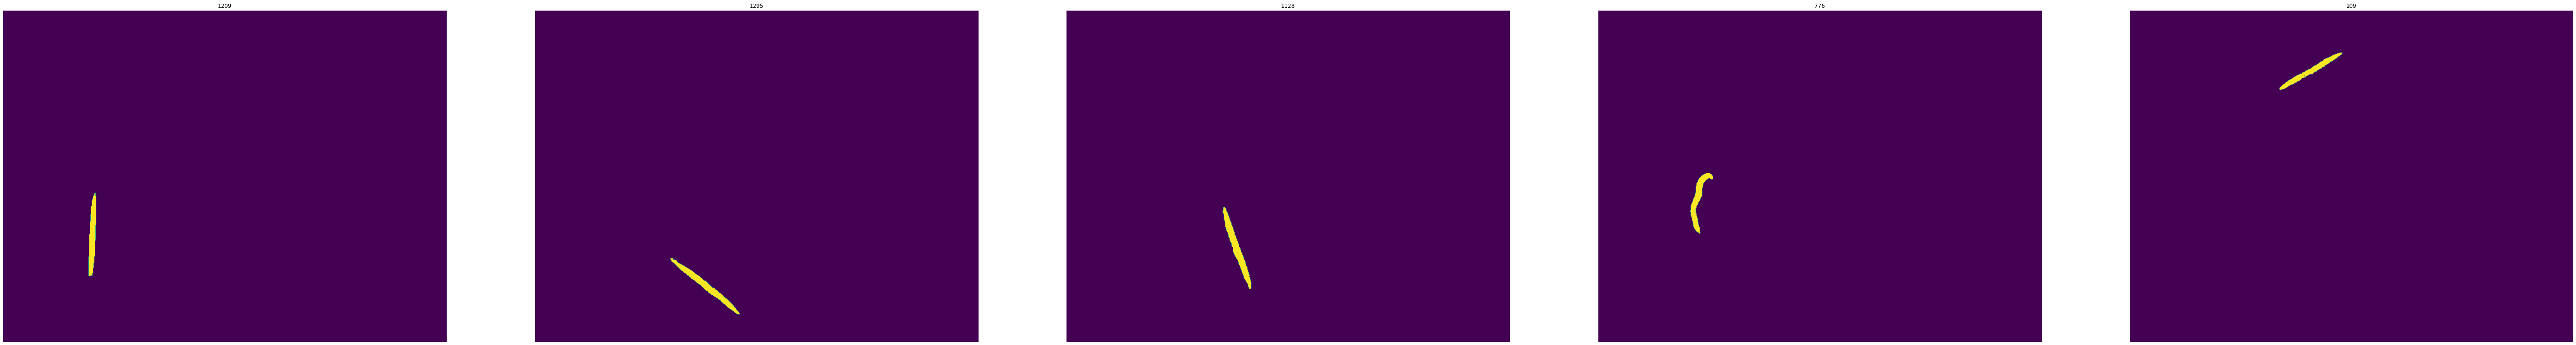

In [3]:
# Your turn!
number=5
inds=np.random.choice(len(imgs)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(100,number*100))
for i in range(0,number):
    ax[i].imshow(imgs[inds[i]])
    ax[i].set_title(str(inds[i]))
    ax[i].axis('off')

**0.3 [FOR BBBC020 ONLY]**: retreive the set of contour points of each individual objects in each image.

*Hint: use the `measure.find_contours` function from `skimage`.*

In [ ]:
from skimage import measure

In [ ]:
# Your turn!
all_objects=[]

for img in imgs:
    img_objects=measure.find_contours(img, 0)
    if len(img_objects)>1:
        ind=np.argmax([len(c) for c in img_objects])  
        all_objects+=[img_objects[ind]]
    else:
        all_objects+=img_objects

**0.3 [FOR BBBC010 ONLY]**: retreive the skeleton of each individual objects in each image.

*Hint: use the `skeletonize` function provided below.*

In [4]:
from skimage import morphology, measure

In [5]:
def order(source, points):
    ordered=[]
    
    current=source
    while len(points)>0:
        dist=[np.linalg.norm(current-points[i]) for i in range(len(points))]
        ind_next=np.argmin(dist)
        current=copy.deepcopy(points[ind_next])
        ordered+=[current]
        points=np.delete(points,ind_next,axis=0)
    
    return np.array(ordered)

In [6]:
def skeletonize(img):
    skeletonized=morphology.skeletonize_3d(img)
    points=np.transpose(np.where(skeletonized>0))

    for p in range(len(points)):
        x, y = points[p,:]
        square=copy.deepcopy(skeletonized[np.max((0,x-1)):np.min((x+2,skeletonized.shape[0])),np.max((0,y-1)):np.min((y+2,skeletonized.shape[1]))])
        square[1,1]=0
        
        source=[]
        if np.max(measure.label(square))==1:
            source=[x,y]
            break
        if len(source)<1:
            source=points[0]
    
    return order(source, points)

In [7]:
# Your turn!
all_objects=[]

for img in imgs:
    img_objects=skeletonize(img)
    all_objects+=[img_objects]

**0.3** Visualize a set of a few randomly selected objects from the collection.

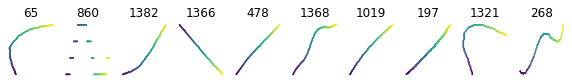

In [8]:
# Your turn!
# This version visualizes the objects only
number=10
inds=np.random.choice(len(all_objects)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number,figsize=(number,1))
for i in range(0,number):
    obj=np.array(all_objects[inds[i]])
    t=np.arange(len(obj))
    ax[i].scatter(obj[:,0],obj[:,1],s=.5,c=t,cmap='viridis')
    ax[i].set_title(str(inds[i]))
    ax[i].axis('off')

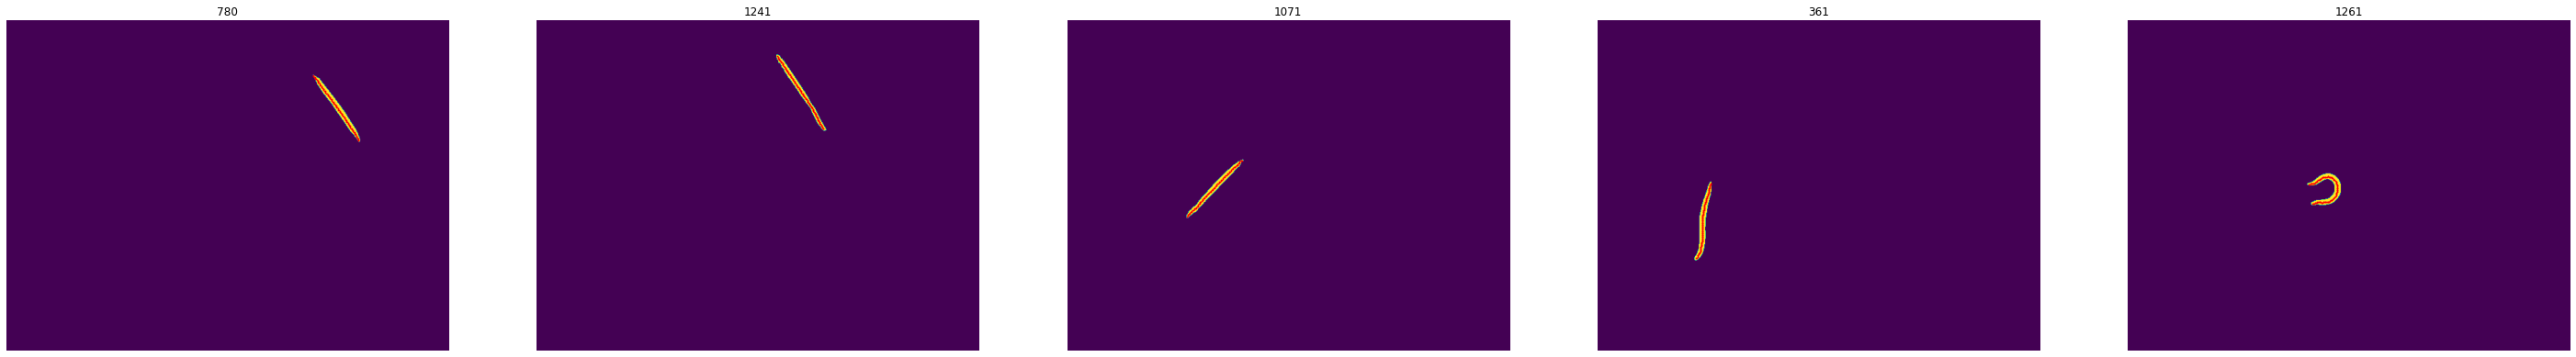

In [9]:
# This version visualizes the objects on top of the mask data
number=5
inds=np.random.choice(len(all_objects)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number,figsize=(10*number,10))
for i in range(0,number):
    obj=np.array(all_objects[inds[i]])
    ax[i].imshow(imgs[inds[i]])
    ax[i].scatter(obj[:,1],obj[:,0],s=.5,c='r')
    ax[i].set_title(str(inds[i]))
    ax[i].axis('off')

### 1. Discrete (point-based) model

**1.1** Extract a set of N equidistant points on each contour. What do you think is a good strategy to choose N? Why?

In [15]:
# Your turn!
Nmax=np.min([len(c) for c in all_objects])
print(Nmax)

56


In [16]:
N=20
point_models=np.zeros((len(all_objects),N,2))

In [ ]:
# This version does not check the real distance between points!
for i in range(len(all_objects)):
    obj=all_objects[i]
    inds=np.round(np.linspace(0,len(obj)-1,N))
    point_models[i]=np.array([obj[int(i)] for i in inds])

In [17]:
# This version does (and uses splines as a bonus)
from scipy.interpolate import interp1d 

def arclength(points):
    dist=[np.linalg.norm(points[i]-points[i-1]) for i in range(1,len(points))]
    return np.hstack(([0],np.cumsum(dist,0)))

def resample(points,N):
    s = arclength(points)
    f = interp1d(s,points,kind='linear',axis=0,assume_sorted=True)
    p = f(np.linspace(0, s[-1], N))
    return p

In [18]:
for i in range(len(all_objects)):
    obj=all_objects[i]
    point_models[i]=np.array(resample(obj,N))

**1.2** Visualize a set of a few randomly selected object models from the collection.

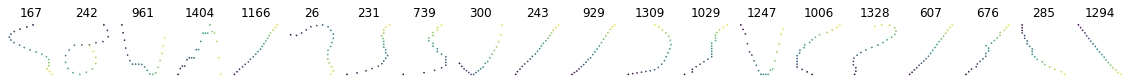

In [19]:
# Your turn!
# This version visualizes the models only
number=20
inds=np.random.choice(len(point_models)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(number,1))
for i in range(0,number):
    point_model=np.array(point_models[inds[i]])
    t=np.arange(len(point_model))
    ax[i].scatter(point_model[:,0],point_model[:,1],s=.5,c=t,cmap='viridis')
    ax[i].set_title(str(inds[i]))
    ax[i].axis('off')

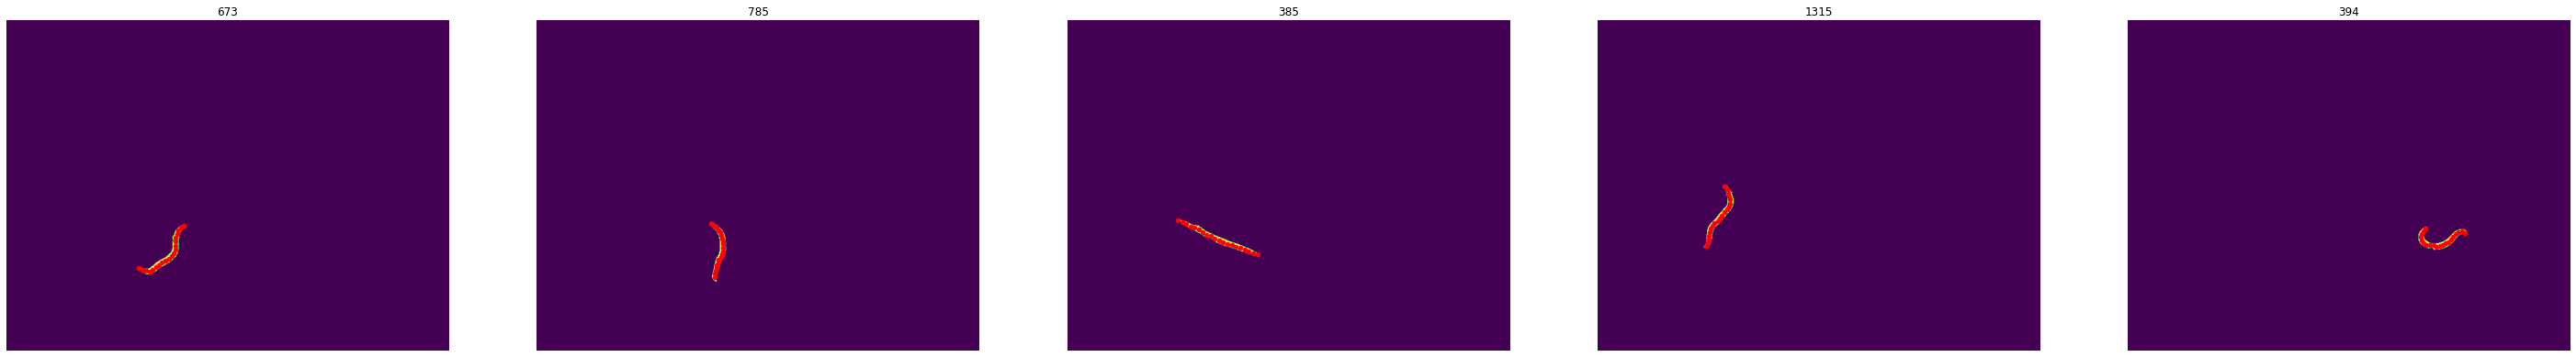

In [20]:
# This version visualizes the models on top of the mask data
number=5
inds=np.random.choice(len(point_models)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number,figsize=(10*number,10))
for i in range(0,number):
    point_model=np.array(point_models[inds[i]])
    ax[i].imshow(imgs[inds[i]])
    ax[i].scatter(point_model[:,1],point_model[:,0],s=20,c='r')
    ax[i].set_title(str(inds[i]))
    ax[i].axis('off')

**1.3** Run the line below to save your shape dataset to a binary file.

In [26]:
np.save(os.path.join(directory,'point_models'),point_models)

### 2. Continuous (spline-based) model